In [18]:
from pathlib import Path
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from IPython.display import display

In [19]:
# Load calibration

""" We need calibrated camera models to rectify and to convert disparity → depth. """

# Paths
DATA = Path("MH_01_Easy_cam")
CAM0_DIR = DATA / "cam0"
CAM1_DIR = DATA / "cam1"

CAL = Path("calibration_output")   # from Task 1
assert CAL.exists(), "Missing calibration_output/ from Task 1"

# Load intrinsics/distortions
d0 = np.load(CAL / "cam0_intrinsics.npz")
d1 = np.load(CAL / "cam1_intrinsics.npz")
K0, dist0 = d0["K"], d0["dist"]
K1, dist1 = d1["K"], d1["dist"]
imsize0 = (int(d0["width"]), int(d0["height"]))   # (w, h)

# Load stereo extrinsics (R,T)
st = np.load(CAL / "stereo_extrinsics.npz")
R, T = st["R"], st["T"]
baseline = float(np.linalg.norm(T))  # meters (the checkerboard units in meters)

print("Loaded calibration:")
print("K0=\n", K0)
print("K1=\n", K1)
print("dist0=", dist0.ravel())
print("dist1=", dist1.ravel())
print("R=\n", R)
print("T=", T.ravel())
print("Baseline (m) =", baseline)
print("Image size (w,h) =", imsize0)


Loaded calibration:
K0=
 [[461.27295302   0.         361.31911058]
 [  0.         459.75826361 247.61789372]
 [  0.           0.           1.        ]]
K1=
 [[459.12670346   0.         373.08564114]
 [  0.         457.74340931 253.99528538]
 [  0.           0.           1.        ]]
dist0= [-3.11914860e-01  1.28378549e-01  4.36021106e-05  9.41519938e-05
 -2.79416919e-02]
dist1= [-3.11642114e-01  1.31979842e-01 -2.19971616e-04  4.06962852e-04
 -3.14582706e-02]
R=
 [[ 0.99999369  0.0027334   0.00226879]
 [-0.00276694  0.99988494  0.01491455]
 [-0.00222776 -0.01492074  0.9998862 ]]
T= [-0.10944116  0.00071261 -0.00093779]
Baseline (m) = 0.10944749874784203
Image size (w,h) = (752, 480)


In [20]:
# Stereo rectification + undistort/rectify maps

""" Rectification warps both views so corresponding points lie on the same row → 
    disparity becomes “horizontal distance”, which enables both sparse and dense stereo. """

flags = 0  # default is fine when stereoCalibrate provided R,T,K,dist
R1, R2, P1, P2, Q, _, _ = cv.stereoRectify(
    cameraMatrix1=K0, distCoeffs1=dist0,
    cameraMatrix2=K1, distCoeffs2=dist1,
    imageSize=imsize0,
    R=R, T=T,
    flags=flags, alpha=0  # alpha=0 => crop to valid region (less black border)
)

# Build rectification maps
map1x, map1y = cv.initUndistortRectifyMap(K0, dist0, R1, P1, imsize0, cv.CV_32FC1)
map2x, map2y = cv.initUndistortRectifyMap(K1, dist1, R2, P2, imsize0, cv.CV_32FC1)

print("Rectification ready. Q matrix:\n", Q)


Rectification ready. Q matrix:
 [[   1.            0.            0.         -304.77445221]
 [   0.            1.            0.         -280.80242538]
 [   0.            0.            0.          479.27179039]
 [   0.            0.            9.13680085  410.15244862]]


Paired frames: 100


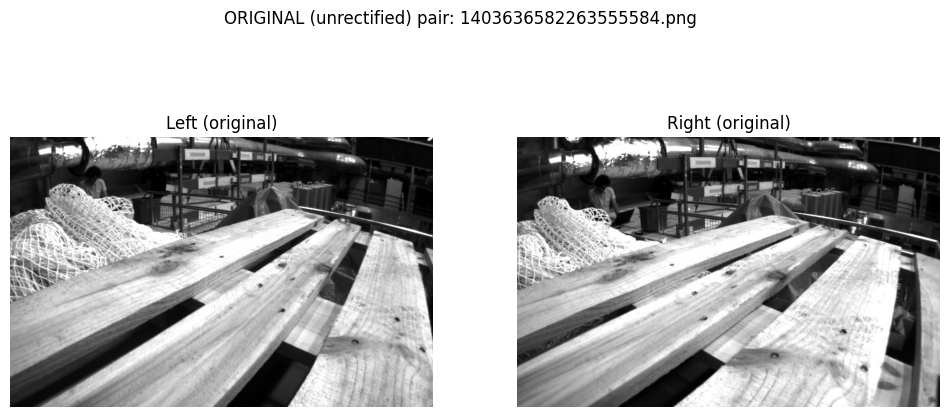

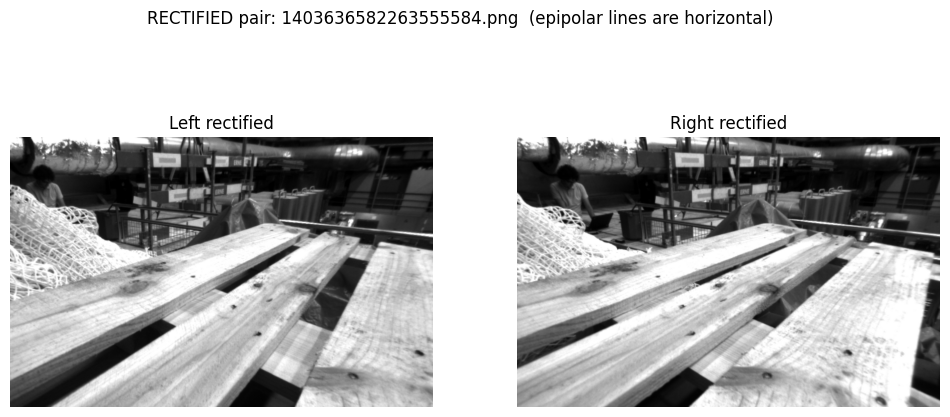

In [24]:
# Load a pair by common filename, rectify & visualize

""" Sanity check that rectification looks good 
    (edges line up horizontally between views). """

# Load one paired frame, show ORIGINAL (unrectified) vs RECTIFIED images

def list_pngs(p):
    return sorted([f.name for f in p.glob("*.png")])

names0 = set(list_pngs(CAM0_DIR))
names1 = set(list_pngs(CAM1_DIR))
common = sorted(names0 & names1)
print("Paired frames:", len(common))
assert len(common) > 0, "No paired PNG filenames found"

# choose any index (middle frame here)
idx = len(common) // 2
fn = common[idx]

# ORIGINAL images (as stored)
imgL = cv.imread(str(CAM0_DIR / fn), cv.IMREAD_GRAYSCALE)
imgR = cv.imread(str(CAM1_DIR / fn), cv.IMREAD_GRAYSCALE)

plt.figure(figsize=(12,5))
plt.suptitle(f"ORIGINAL (unrectified) pair: {fn}", y=1.02)
plt.subplot(1,2,1); plt.title("Left (original)");  plt.imshow(imgL, cmap="gray"); plt.axis("off")
plt.subplot(1,2,2); plt.title("Right (original)"); plt.imshow(imgR, cmap="gray"); plt.axis("off")
plt.show()

# RECTIFIED images (warp with the precomputed maps)
# map1x/map1y, map2x/map2y must come from cv.initUndistortRectifyMap(...)
rectL = cv.remap(imgL, map1x, map1y, interpolation=cv.INTER_LINEAR)
rectR = cv.remap(imgR, map2x, map2y, interpolation=cv.INTER_LINEAR)

plt.figure(figsize=(12,5))
plt.suptitle(f"RECTIFIED pair: {fn}  (epipolar lines are horizontal)", y=1.02)
plt.subplot(1,2,1); plt.title("Left rectified");  plt.imshow(rectL, cmap="gray"); plt.axis("off")
plt.subplot(1,2,2); plt.title("Right rectified"); plt.imshow(rectR, cmap="gray"); plt.axis("off")
plt.show()


Good matches: 185
Depth stats (m) on matched points:
count=12, min=0.317, median=0.834, mean=0.811, max=1.320


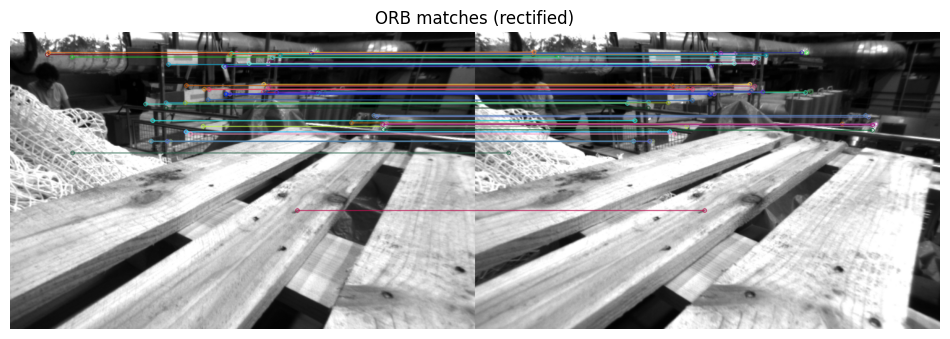

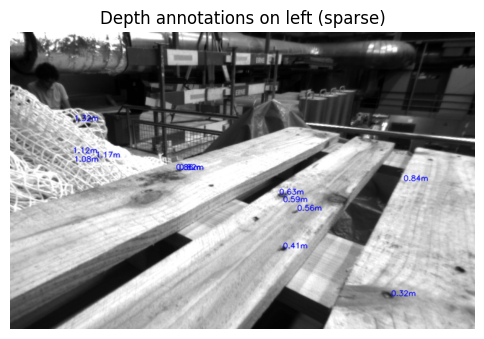

In [25]:
# Sparse features & per-match depth
# Use the rectified images from above: rectL, rectR

""" for a quick depth sanity check on selected points.
    We use ORB (fast, rotation-invariant) + BFMatcher (Hamming) with a Lowe's ratio test, 
    then compute disparity by the difference in rectified x-coordinates. """

# ORB features
orb = cv.ORB_create(nfeatures=2000, fastThreshold=7, scaleFactor=1.2)
kpsL, desL = orb.detectAndCompute(rectL, None)
kpsR, desR = orb.detectAndCompute(rectR, None)

# Match with ratio test
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=False)
knn = bf.knnMatch(desL, desR, k=2)

good = []
for m, n in knn:
    if m.distance < 0.7 * n.distance:
        ptL = np.array(kpsL[m.queryIdx].pt)
        ptR = np.array(kpsR[m.trainIdx].pt)
        # epipolar constraint after rectification
        if abs(ptL[1] - ptR[1]) < 2.0:  # 2-pixel vertical tolerance
            good.append((m, ptL, ptR))

print("Good matches:", len(good))

# Disparity & depth from matches
f_rect = P1[0,0]          # focal length in pixels after rectification
B_rect = abs(P2[0,3]/P1[0,0]) if P1[0,0] != 0 else baseline  # meters
depths = []
rows_to_draw = []

for m, ptL, ptR in good:
    disp = (ptL[0] - ptR[0])  # horizontal disparity
    if disp > 0.5:            # avoid tiny/negative disparities
        Z = f_rect * B_rect / disp
        depths.append((int(ptL[0]), int(ptL[1]), float(Z)))
        rows_to_draw.append(m)

print("Depth stats (m) on matched points:")
if depths:
    zs = np.array([z for _,_,z in depths])
    print(f"count={len(zs)}, min={zs.min():.3f}, median={np.median(zs):.3f}, mean={zs.mean():.3f}, max={zs.max():.3f}")
else:
    print("No valid disparities found.")

# Draw matches and annotate a few depths on the left image
vis = cv.drawMatches(rectL, kpsL, rectR, kpsR, [m for m,_,_ in good[:60]], None,
                     flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(12,6))
plt.title("ORB matches (rectified)")
plt.imshow(vis[..., ::-1])  # BGR->RGB if color
plt.axis("off")
plt.show()

# Depth annotations on left image
ann = cv.cvtColor(rectL, cv.COLOR_GRAY2BGR)
for (x, y, Z) in depths[:50]:  # annotate up to 50
    cv.putText(ann, f"{Z:.2f}m", (x, y), cv.FONT_HERSHEY_SIMPLEX, 0.4, (255,0,0), 1, cv.LINE_AA)

plt.figure(figsize=(6,5))
plt.title("Depth annotations on left (sparse)")
plt.imshow(ann[..., ::-1])
plt.axis("off")
plt.show()


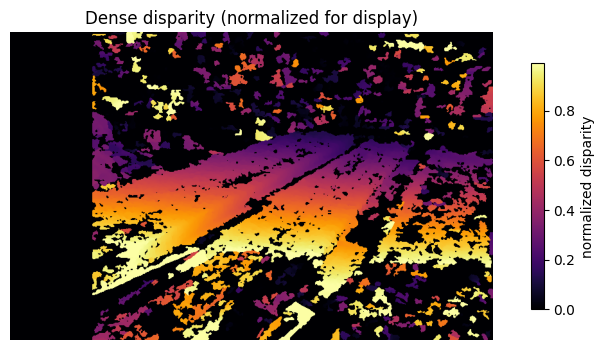

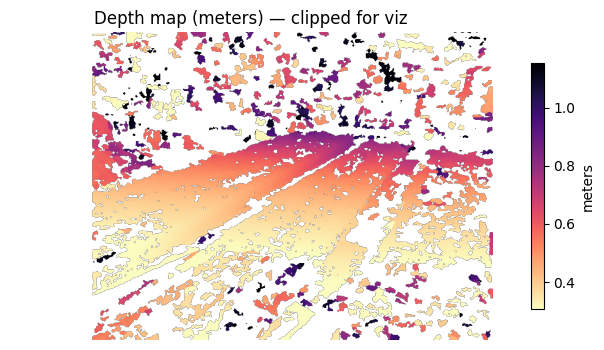

In [28]:
# Dense disparity with SGBM + depth map via Q

""" A full disparity map per pixel gives a depth map """

min_disp = 0
num_disp = 128  # must be divisible by 16 (OpenCV req); 96/128/160 depending on scene
block_size = 5  # 3..9 typical
P1 = 8 * 1 * block_size**2
P2 = 32 * 1 * block_size**2

sgbm = cv.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=block_size,
    P1=P1, P2=P2,
    disp12MaxDiff=1,
    uniquenessRatio=10,
    speckleWindowSize=50,
    speckleRange=2,
)

disp = sgbm.compute(rectL, rectR).astype(np.int16)
disp_float = disp.astype(np.float32) / 16.0  # SGBM scales by 16

# Visualization
disp_vis = (disp_float - min_disp) / num_disp
disp_vis = np.clip(disp_vis, 0, 1)

plt.figure(figsize=(10,4))
plt.title("Dense disparity (normalized for display)")
plt.imshow(disp_vis, cmap="inferno")
plt.colorbar(shrink=0.8, label="normalized disparity")
plt.axis("off")
plt.show()

# Depth via Q (reprojection)
points_3d = cv.reprojectImageTo3D(disp_float, Q)   # returns XYZ per pixel
Z = points_3d[:,:,2]                               # depth in same units as baseline

# Mask invalid (disparity <= 0)
Z_mask = (disp_float > 0.5) & np.isfinite(Z) & (Z < 1000)  # cap far depths

plt.figure(figsize=(10,4))
plt.title("Depth map (meters) — clipped for viz")
Z_show = np.where(Z_mask, Z, np.nan)
plt.imshow(Z_show, cmap="magma_r")
plt.colorbar(shrink=0.8, label="meters")
plt.axis("off")
plt.show()


In [27]:
print("Depth range:", np.nanmin(Z_show), np.nanmax(Z_show))

Depth range: 0.3051664 1.15406
